# Tutorial 1
This shows how qdiv can be used to analyze data from 16S amplicon sequencing experiments. In this tutorial, we focus on preparing the data for analysis, checking the most abundant taxa, and calculating alpha and beta diversity.

The example data in this tutorial is from an experiment with microbial fuel cells (MFCs) and can be found at [qdiv's github pages](https://github.com/omvatten/qdiv/tree/master/example_files). The data set has 8 samples: 4 samples are from acetate-fed MFCs and 4 are from glucose-fed MFC. The meta data file shows information about the samples.

## TABLE OF CONTENTS
* [Prepare the data files](#PREPARE-THE-DATA-FILES)
* [A first look at the data](#A-FIRST-LOOK-AT-THE-DATA)
* [Rarefying](#RAREFYING)
* [Alpha diversity](#ALPHA-DIVERSITY)
* [Beta diversity](#BETA-DIVERSITY)

## PREPARE THE DATA FILES
Let's assume we have two count tables: one generated with DADA2 and one with UNOISE. For each count table we also have a fasta file with the sequences and a meta data file. All files are located in a folder called 'tutorial/'. We will inspect the data, make a consensus count table, and save the results.
* [Inspect the data](#Inspect-the-data)
* [Consensus count table](#Consensus-count-table)
* [Changing taxonomic information](#Changing-taxonomic-information)
* [Save files](#Save-files)

### Inspect the data
Run the code below to inspect the data.

In [1]:
import qdiv

path_to_folder = '../example_files/'
metadata = 'example_metadata.csv'
unoise_tab = 'example_Unoise_table.csv'
unoise_seq = 'example_Unoise_seq.fa'
dada2_tab = 'example_DADA2_table.csv'
dada2_seq = 'example_DADA2_seq.fa'

#Load the files into qdiv objects and inspect the data
print('CHECKING THE DADA2 DATA:')
dada2_obj = qdiv.files.load(path=path_to_folder, tab=dada2_tab, fasta=dada2_seq, meta=metadata)
qdiv.stats.print_info(dada2_obj)
print('--------------')

print('CHECKING THE UNOISE DATA:')
unoise_obj = qdiv.files.load(path=path_to_folder, tab=unoise_tab, fasta=unoise_seq, meta=metadata)
qdiv.stats.print_info(unoise_obj)
print('--------------')

CHECKING THE DADA2 DATA:
Running files.load .. Done!
Dataframes in object: ['tab', 'ra', 'tax', 'seq', 'meta']
Total number of samples=  8
Total number of ASVs=  108
Total reads=  877889
Minimum number of reads in a sample=  50627
Taxonomic levels: ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
Column headings in meta data:
['feed', 'order']
First row in meta data:
['acetate', 1]
--------------
CHECKING THE UNOISE DATA:
Running files.load .. Done!
Dataframes in object: ['tab', 'ra', 'seq', 'meta']
Total number of samples=  8
Total number of ASVs=  98
Total reads=  1062191
Minimum number of reads in a sample=  63754
Column headings in meta data:
['feed', 'order']
First row in meta data:
['acetate', 1]
--------------


We see that we have 8 samples in the data set. We can also see that in the DADA2 count table we have 108 ASVs and in the UNOISE table with have 98. The DADA2 count table also contain taxonomic information, the UNOISE table does not.
We decide to make a consensus table based on the two count tables.

### Consensus count table
The input to the *subset.consensus* command is a list of the qdiv objects used to build the consensus table. We input the following list \[dada2_obj, unoise_obj\]. Since we only have taxonomic information in the DADA2 table, we specify that we want to keep this information in the consensus table. This is done by setting the input parameter *taxa* to the position in the list occupied by the DADA2 object. In Python, the first item in a list is at position 0, so we specify *taxa=0*.

In [2]:
cons_obj, info = qdiv.subset.consensus([dada2_obj, unoise_obj], taxa=0)
print(info)

Running subset.consensus..
Aligning ASVs in 2 objects: 1.. 2.. 
Changing ASV names in 2 objects: 1.. 2.. 
Done with subset.align_sequences
Done with subset.consensus (note that this function does not keep tree in the object).
{'Kept obj pos': 1, 'Relative abundance (%) of reads associated with retained ASVs': [98.06342259670642, 98.68978366414326], 'Maximum relative abundance (%) of lost reads in a sample': [2.7677307752791322, 2.5104796466388977]}


From the print(info) statement we can see the the object in position 1 in the input list was kept and subsetted to the consensus ASVs (that is the unoise_obj), 98.69% of the reads were associated with consensus ASVs; and in the individual samples, the maximum relative abundance associated with discarded ASVs was 2.51%.
We can also use the qdiv.stats.print_info function to get more information about the consensus object we have generated.

In [3]:
qdiv.stats.print_info(cons_obj)

Dataframes in object: ['tab', 'ra', 'seq', 'meta', 'tax']
Total number of samples=  8
Total number of ASVs=  82
Total reads=  1048274
Minimum number of reads in a sample=  62508
Taxonomic levels: ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
Column headings in meta data:
['feed', 'order']
First row in meta data:
['acetate', 1]


Here we can see we have a total of 82 ASVs in the consensus object. This can be compared to 108 and 98 ASVs in the original DADA2 and Unoise count tables, respectively.

### Changing taxonomic information
Let's say we are not happy we the taxonomic information we have in the object and we want to change it. Or perhaps we didn't even have any taxonomic information from the beginning. qdiv has options to add taxonomy from files generated with RDP, sintax, and the SINA classifiers. In this case, we want to add sintax-generated taxonomy from the file Consensus_sintax.txt located in the example_files/ folder.

In [4]:
cons_obj = qdiv.files.read_sintax(cons_obj, '../example_files/Consensus_sintax.txt')

To check the taxonomy dataframe specifically, we can run the following command using the Python package pandas. (Note that a qdiv object is bunch of pandas dataframes.) 

In [6]:
import pandas as pd
print(cons_obj['tax'].head())

            Domain             Phylum                   Class  \
ASV1   d__Bacteria  p__Proteobacteria  c__Deltaproteobacteria   
ASV10  d__Bacteria   p__Bacteroidetes          c__Bacteroidia   
ASV11  d__Bacteria    p__Spirochaetes         c__Spirochaetia   
ASV12  d__Bacteria   p__Bacteroidetes          c__Bacteroidia   
ASV13  d__Bacteria   p__Synergistetes          c__Synergistia   

                       Order              Family            Genus  \
ASV1                     NaN                 NaN              NaN   
ASV10       o__Bacteroidales    f__Rikenellaceae  g__midas_g_6724   
ASV11      o__Spirochaetales  f__Spirochaetaceae  g__midas_g_5121   
ASV12  o__Sphingobacteriales                 NaN              NaN   
ASV13       o__Synergistales   f__Synergistaceae   g__midas_g_249   

               Species  
ASV1               NaN  
ASV10  s__midas_s_6724  
ASV11  s__midas_s_5121  
ASV12              NaN  
ASV13              NaN  


### Save files
Ok, now we are happy with our consensus object. We save the files to have them for later analysis.

In [7]:
qdiv.files.printout(cons_obj, path='../example_files/', savename='Consensus')

Files saved


## A FIRST LOOK AT THE DATA
* [Number of different taxa](#Number-of-different-taxa)
* [Heatmap](#Heatmap)

Ok, we are done with making a consensus table and preparing the data and now want to see how the data looks. First, we load our consensus files into a qdiv object.

In [9]:
import qdiv

path_to_folder = '../example_files/'
metadata = 'Consensus_meta.csv'
cons_tab = 'Consensus_table.csv'
cons_seq = 'Consensus_seq.fa'

obj = qdiv.files.load(path=path_to_folder, tab=cons_tab, fasta=cons_seq, meta=metadata)

Running files.load .. Done!


Now our files are loaded as a qdiv object called *obj*. We will use a heatmap to see the relative abundance of the most abundant taxa and we will save a file with information about the number of different taxa in the samples.

### Number of different taxa
Here we will get information about the number of different taxa in the samples. The following command will save a csv-file with the name 'Stats_on_taxa.csv' in the folder specified by the variable *path* in the code block above (i.e. '../example_files/').  The results will also be stored in a variable called *results*, which we will display with the print command.

In [10]:
result = qdiv.stats.taxa(obj, savename=path_to_folder+'Stats_on_taxa')
print(result)

        ASVs    Reads  Domain  Phylum  Class  Order  Family  Genus  Species
Sample                                                                     
Total     82  1048274       1       9     17     19      26     31       33
Smp1      64   192457       1       8     14     15      23     26       25
Smp2      67    79318       1       8     15     16      23     27       26
Smp3      68   164746       1       8     16     17      24     28       27
Smp4      66    77709       1       8     15     17      25     29       28
Smp5      69    97577       1       9     15     17      23     28       30
Smp6      71   147216       1       9     17     19      25     29       30
Smp7      67    62508       1       9     16     18      24     28       29
Smp8      71   226743       1       9     17     19      25     29       30


Here, we see that in total we have 9 phyla, 17 classes, 19 orders, 26 families, and 31 genera, and 33 different species classified taxonomically in our samples. For 16S amplicon sequencing data we will often get higher numbers under Genus than under Species. The reason is that very few ASVs are classified to the species level.

### Heatmap
The following command plots a heatmap. We specify that we want to include the 20 most abundant taxa, that the ASVs should be grouped at the genus level, and that the phylum level taxonomy should also be shown. The *plot.heatmap* command has many options for customizing the plot. See the [documentation](https://qdiv.readthedocs.io/en/latest/Plotting.html).

<IPython.core.display.Javascript object>


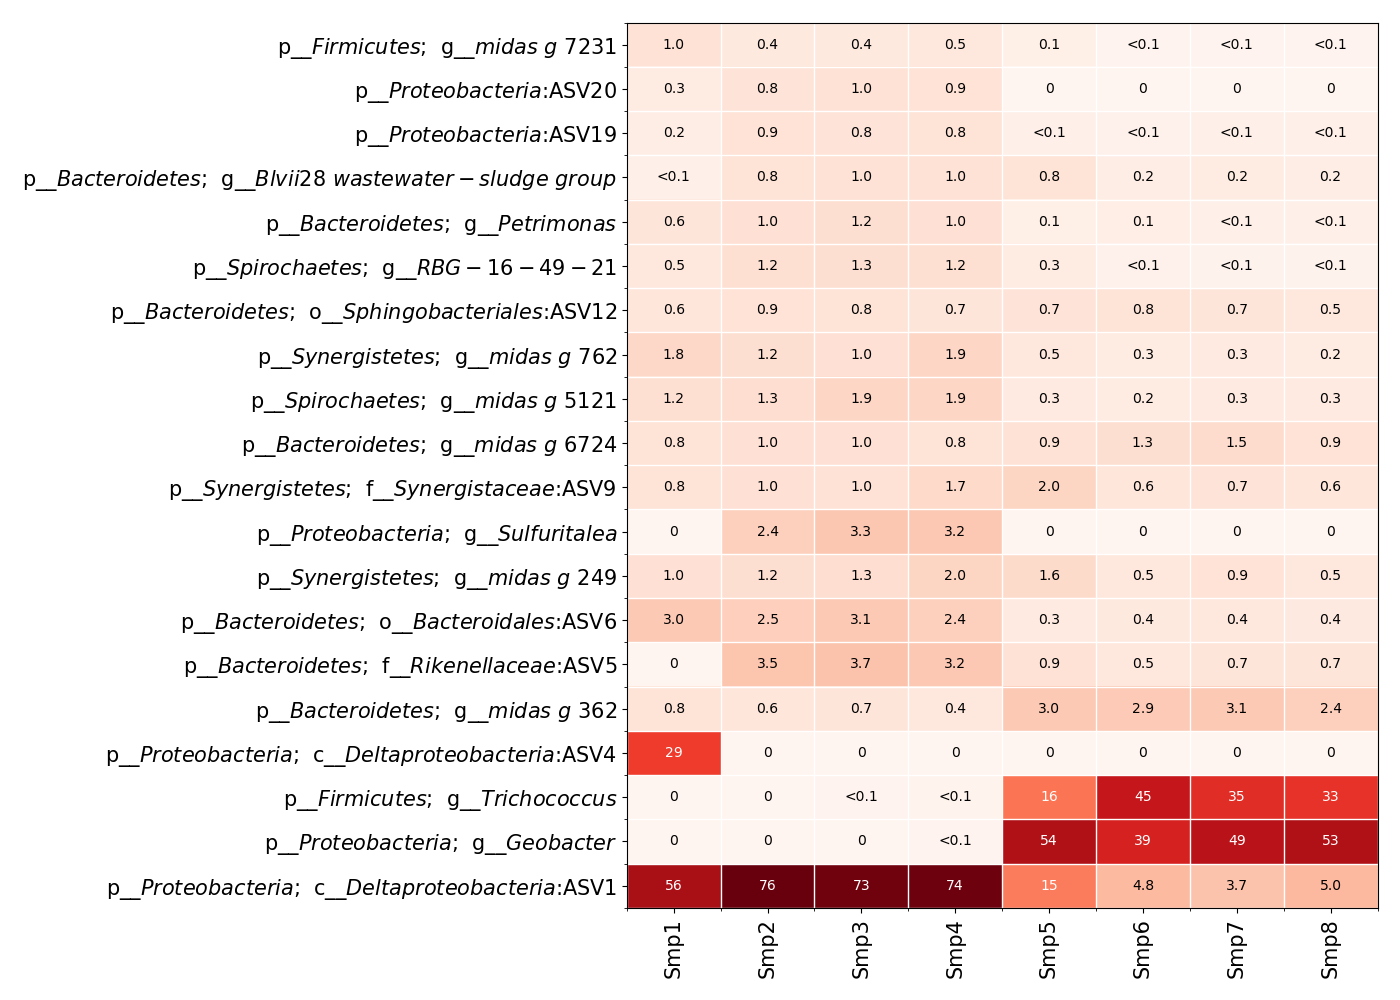

In [13]:
%matplotlib notebook
qdiv.plot.heatmap(obj, numberToPlot=20, levels=['Phylum', 'Genus'])

## RAREFYING
Before we start calculating diversity indices, we rarefy the count table. This makes sure that each sample has the same number of reads so that we can make a "fair" comparison of the diversity in the samples. The following command stores the rarefied qdiv object in a variable called *robj*. By setting the *seed* parameter to a number, the rarefying (which is a random process) becomes reproducible. Here, I decided to set the seed to 19 (just pick whatever number you like). This means that if I want to reproduce the rarefied data from the same input in the future, I can use the same seed.

In [14]:
robj = qdiv.subset.rarefy_object(obj, seed=19)

## ALPHA DIVERSITY
* [Alpha diversity profiles](#Alpha-diversity-profiles)
* [Naive-, phylogenetic-, or functional diversity](#Naive-,-phylogenetic-,-or-functional-diversity)

Alpha diversity is the diversity within each sample. Alpha diversity should be quantified using Hill numbers (also called effective numbers). 

Consider a hypothetical microbial community with 10 equally abundant species. The most logical diversity number for this community would be 10. Hill numbers are great because they will always result in a value of 10 for this community.

Consider a hypothetical microbial community with 2 species with high relative abundance and 8 species with low relative abundance. What is the most logical diversity number now? If we don't care about relative abundance information, 10 would be the most logical value. If we don't care about rare species, 2 would be the most logical value. Hill numbers are great because we can fine-tune the importance of relative abundance using a single parameter called the diversity order.

The equation for calculating Hill numbers is the following:

$^q$D=$(\sum_{i=1}^{S} p_{i}^{q})^{\frac{1}{1-q}}$  

$^q$D is the Hill number (or effective number) of order q; q is the diversity order; p$_{i}$ is the relative abundance of the i$^{th}$ ASV in a sample; S is the total number of ASVs. 

When q=1, the above equation becomes:

$^1$D=$\exp(-\sum_{i=1}^{S} p_{i} \times ln(p_{i}))$  

As you can see in the equations, when q=0, $^0$D is simply equal to the total number of ASVs in the sample (this is often referred to as *richness*). When q=1, each ASV is weighted exactly according to its relative abundance; and when q>1, we give more weight to ASVs with high relative abundance. Thus, in a community with 2 abundant and 8 rare species, $^q$D will be 10 when q=0 and $^q$D will approach 2 as q gets higher and higher.

### Alpha diversity profiles
Now it is time to look at alpha diversity. We start by plotting diversity as a function of the diversity order (q) using the command *plot.alpha_diversity*. By setting the *var* parameter to a column heading in the meta data file, we can color code the lines in the plot. I use the rarefied qdiv object, *robj*, as input.

<IPython.core.display.Javascript object>


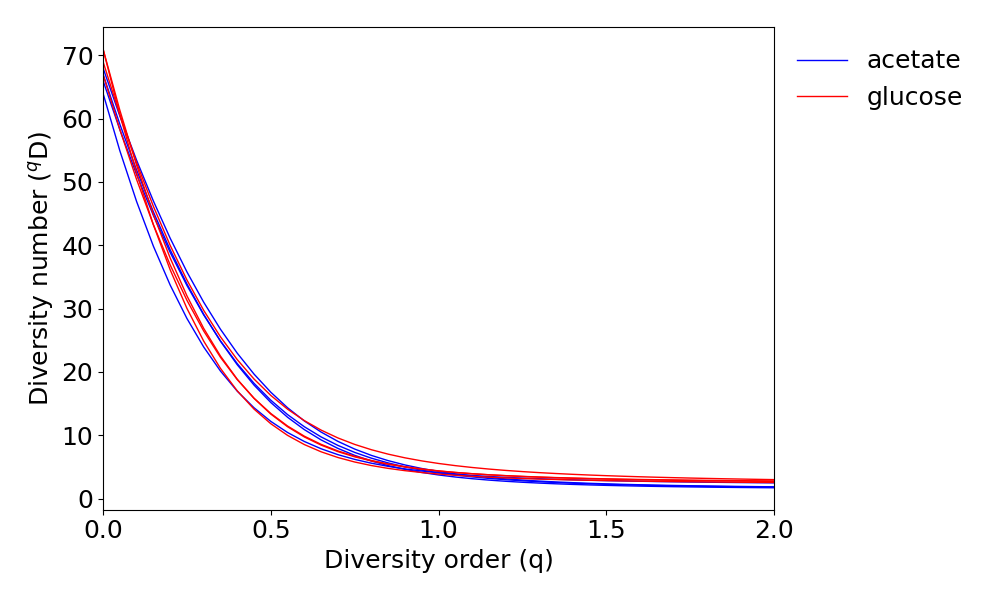

In [15]:
qdiv.plot.alpha_diversity(robj, var='feed')

### Naive-, phylogenetic-, or functional diversity
One way to calculate diversity is to consider all ASVs as separate entities and not care about relationships between individual ASVs. We call these diversity values *naive*.

A second way to calculate diversity takes the relationships in a phylogenetic tree into account. Two ASVs that share many branches in the tree contribute less to diversity than two ASVs that are very far from each other in the tree. We call the diversity values that are calculated with a tree as input *phylogenetic*.

A third way to calculate diversity takes the pairwise distances between ASVs into account. Two ASVs that have a small pairwise distance contribute less to diversity than two that have a high pairwise distance. We call the diversity values that are calculated with a distance matrix as input *functional*.

Naive alpha diversity is simply the effective number of ASVs, phylogenetic alpha diversity is the effective branch diversity in the phylogenetic tree associated with the ASVs in the sample, and functional alpha diversity is the effective total distance between ASVs in the sample. The word "effective" used above refers to the relative abundance weighting by the diversity order, q.

To calculate the naive alpha diversity for any diversity order (q), we can use the following command.

In [16]:
naive_1D = qdiv.diversity.naive_alpha(robj['tab'], q=1)
print(naive_1D)

Smp1    4.082758
Smp2    3.736072
Smp3    4.294697
Smp4    4.076211
Smp5    5.550454
Smp6    4.360946
Smp7    4.382288
Smp8    3.883477
dtype: float64


## BETA DIVERSITY
* [PCoA](#PCoA)

The framework of naive-, phylogenetic-, and functional Hill numbers described under alpha diversity [above](#ALPHA-DIVERSITY) can be extended to beta diversity. When we study beta diversity, we often calculate dissimilarity values that are constrained between 0 and 1. A value of 0 means that two samples have identical community compostion. A value of 1 means they are completely different (no shared taxa). Also check the description of beta diversity at the [documentation](https://qdiv.readthedocs.io/en/latest/Diversity%20calculations.html#beta-diversity-dissimilarity) 

We can calculate matrices of pairwise naive Hill-based dissimilarity values between samples with the following commands.

In [17]:
naive_1d = qdiv.diversity.naive_beta(robj['tab'], q=1)
print(naive_1d)

          Smp1      Smp2      Smp3      Smp4      Smp5      Smp6      Smp7  \
Smp1  0.000000  0.203052  0.207850  0.204899  0.654659  0.809122  0.824744   
Smp2  0.203052  0.000000  0.002771  0.004165  0.590657  0.777056  0.791329   
Smp3  0.207850  0.002771  0.000000  0.004736  0.591257  0.775696  0.789560   
Smp4  0.204899  0.004165  0.004736  0.000000  0.587958  0.777243  0.789710   
Smp5  0.654659  0.590657  0.591257  0.587958  0.000000  0.096557  0.066893   
Smp6  0.809122  0.777056  0.775696  0.777243  0.096557  0.000000  0.011349   
Smp7  0.824744  0.791329  0.789560  0.789710  0.066893  0.011349  0.000000   
Smp8  0.809596  0.775089  0.774091  0.774143  0.055951  0.018114  0.004616   

          Smp8  
Smp1  0.809596  
Smp2  0.775089  
Smp3  0.774091  
Smp4  0.774143  
Smp5  0.055951  
Smp6  0.018114  
Smp7  0.004616  
Smp8  0.000000  


### PCoA
Rather than looking at all the numbers in the dissimilarity matrices, principle coordinate analysis (PCoA) makes it easier to understand the data. The *plot.pcoa* command requires a minimum of three inputs: the dissimilarity matrix, the meta data, and a heading of a meta data column with categories that color code the samples. Here is an example for the naive dissimilarity values.

<IPython.core.display.Javascript object>


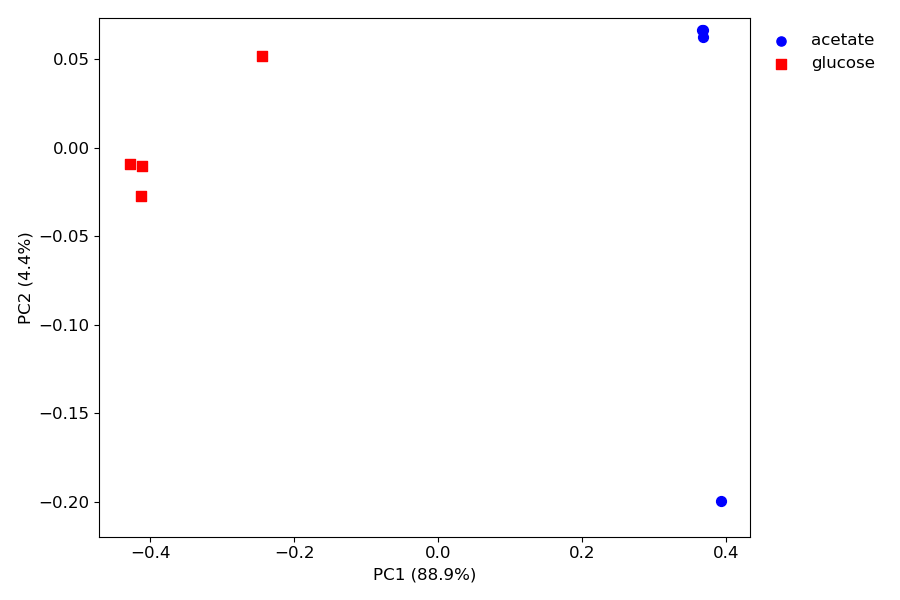

In [18]:
qdiv.plot.pcoa(naive_1d, robj['meta'], var1='feed')

We can see a clear separation between the acetate- and glucose-fed MFCs along the x-axis, which explains 88.9% of the variation in the data. There are many options for customizing the PCoA plot. For example, the width and height can be changed with the parameter *figsize*. See the [documentation](https://qdiv.readthedocs.io/en/latest/Plotting.html).